In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
df = pd.read_csv("../Data/Processed/cleaned_bridge_dataset_V1.csv")
df.head()

,acceleration_x,acceleration_y,acceleration_z,temperature_c,humidity_percent,wind_speed_mps,fft_peak_freq,fft_magnitude,degradation_score,structural_condition,damage_class,forecast_score_next_30d,date,time
0,-0.428902,0.009163,-0.448430,24.263205,82.573476,9.129824,3.264360,1.393159,75.155898,3,Severe,83.164753,2020-01-01,00:00:00
1,0.086893,-0.005482,0.422973,19.343838,83.545112,6.676185,1.290251,0.190976,10.844521,0,No Damage,16.168653,2020-01-01,00:15:00
2,-0.168531,-0.703500,-0.403903,18.021082,41.881540,1.084121,4.899752,1.402845,61.673974,2,Moderate,65.254881,2020-01-01,00:30:00
3,-0.242926,-0.046838,-0.359685,19.908278,81.787200,0.003722,2.347590,0.659239,26.573856,1,Minor,29.030163,2020-01-01,00:45:00
4,0.175638,0.000792,-0.242574,30.995286,89.394147,1.032235,0.928626,0.733460,38.942145,1,Minor,34.534451,2020-01-01,01:00:00


# Feature Engineering

## Vibration Features
Vibration: RMS, Peak, Frequency domain features (fft_peak_freq, fft_magnitude are already present)

In [4]:
## Vibration Features
vibration_cols = ["acceleration_x" , "acceleration_y" , "acceleration_z"]

In [5]:
#RMS
df['vibration_rms'] = np.sqrt(df['acceleration_x']**2 + df['acceleration_y']**2 + df['acceleration_z']**2)

In [6]:
df.head()

,acceleration_x,acceleration_y,acceleration_z,temperature_c,humidity_percent,wind_speed_mps,fft_peak_freq,fft_magnitude,degradation_score,structural_condition,damage_class,forecast_score_next_30d,date,time,vibration_rms
0,-0.428902,0.009163,-0.448430,24.263205,82.573476,9.129824,3.264360,1.393159,75.155898,3,Severe,83.164753,2020-01-01,00:00:00,0.620588
1,0.086893,-0.005482,0.422973,19.343838,83.545112,6.676185,1.290251,0.190976,10.844521,0,No Damage,16.168653,2020-01-01,00:15:00,0.431841
2,-0.168531,-0.703500,-0.403903,18.021082,41.881540,1.084121,4.899752,1.402845,61.673974,2,Moderate,65.254881,2020-01-01,00:30:00,0.828524
3,-0.242926,-0.046838,-0.359685,19.908278,81.787200,0.003722,2.347590,0.659239,26.573856,1,Minor,29.030163,2020-01-01,00:45:00,0.436556
4,0.175638,0.000792,-0.242574,30.995286,89.394147,1.032235,0.928626,0.733460,38.942145,1,Minor,34.534451,2020-01-01,01:00:00,0.299485


In [7]:
df['vibration_peak'] = df[['acceleration_x', 'acceleration_y', 'acceleration_z']].abs().max(axis=1)

## Temperature Features
Temperature: Average, deviation

In [8]:
df['datetime'] = pd.to_datetime(df['date'] + ' ' + df['time'])

# Set datetime as index (optional, makes rolling easier)
df = df.set_index('datetime')

#### Average Temperature

In [9]:
# 2-hour rolling average - for short_term context
df['avg_temp_2h'] = df['temperature_c'].rolling('2H', min_periods=1).mean()

# 1-day rolling average (96 samples for 15-min data) - for long_term context
df['avg_temp_1d'] = df['temperature_c'].rolling(window=96, min_periods=1).mean()


C:\Users\PMLS\AppData\Local\Temp\ipykernel_9800\2620919637.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df['avg_temp_2h'] = df['temperature_c'].rolling('2H', min_periods=1).mean()


### Temperature Deviation

In [10]:
#for 2 hours
df["temp_deviation_2h"] = df["temperature_c"] - df["avg_temp_2h"]
#for 24 hours
df["temp_deviation_2h"] = df["temperature_c"] - df["avg_temp_1d"]

In [11]:
df["wind_speed_mps"].head(20)

datetime
2020-01-01 00:00:00     9.129824
2020-01-01 00:15:00     6.676185
2020-01-01 00:30:00     1.084121
2020-01-01 00:45:00     0.003722
2020-01-01 01:00:00     1.032235
2020-01-01 01:15:00     5.584154
2020-01-01 01:30:00     1.937815
2020-01-01 01:45:00     6.412842
2020-01-01 02:00:00     4.433310
2020-01-01 02:15:00    10.603704
2020-01-01 02:30:00    12.721583
2020-01-01 02:45:00     1.485716
2020-01-01 03:00:00     9.810276
2020-01-01 03:15:00    14.058373
2020-01-01 03:30:00     5.601471
2020-01-01 03:45:00     8.954895
2020-01-01 04:00:00    12.698677
2020-01-01 04:15:00     1.121927
2020-01-01 04:30:00     7.888558
2020-01-01 04:45:00    14.816713
Name: wind_speed_mps, dtype: float64

### Wind Features

In [12]:
# 2-hour rolling max gusts
df['wind_max_gust_2h'] = df['wind_speed_mps'].rolling('2h', min_periods=1).max()

# 2-hour rolling average wind speed
df['wind_avg_2h'] = df['wind_speed_mps'].rolling('2h', min_periods=1).mean()



In [13]:
# 1-day rolling max gusts
df['wind_max_gust_1d'] = df['wind_speed_mps'].rolling(window=96, min_periods=1).max()

# 1-day rolling average wind speed
df['wind_avg_1d'] = df['wind_speed_mps'].rolling(window=96, min_periods=1).mean()

In [14]:
df.head(30)

,acceleration_x,acceleration_y,acceleration_z,temperature_c,humidity_percent,wind_speed_mps,fft_peak_freq,fft_magnitude,degradation_score,structural_condition,...,time,vibration_rms,vibration_peak,avg_temp_2h,avg_temp_1d,temp_deviation_2h,wind_max_gust_2h,wind_avg_2h,wind_max_gust_1d,wind_avg_1d
datetime,,,,,,,,,,,,,,,,,,,,,
2020-01-01 00:00:00,-0.428902,0.009163,-0.448430,24.263205,82.573476,9.129824,3.264360,1.393159,75.155898,3,...,00:00:00,0.620588,0.448430,24.263205,24.263205,0.000000,9.129824,9.129824,9.129824,9.129824
2020-01-01 00:15:00,0.086893,-0.005482,0.422973,19.343838,83.545112,6.676185,1.290251,0.190976,10.844521,0,...,00:15:00,0.431841,0.422973,21.803522,21.803522,-2.459683,9.129824,7.903004,9.129824,7.903004
2020-01-01 00:30:00,-0.168531,-0.703500,-0.403903,18.021082,41.881540,1.084121,4.899752,1.402845,61.673974,2,...,00:30:00,0.828524,0.703500,20.542709,20.542709,-2.521626,9.129824,5.630043,9.129824,5.630043
2020-01-01 00:45:00,-0.242926,-0.046838,-0.359685,19.908278,81.787200,0.003722,2.347590,0.659239,26.573856,1,...,00:45:00,0.436556,0.359685,20.384101,20.384101,-0.475823,9.129824,4.223463,9.129824,4.223463
2020-01-01 01:00:00,0.175638,0.000792,-0.242574,30.995286,89.394147,1.032235,0.928626,0.733460,38.942145,1,...,01:00:00,0.299485,0.242574,22.506338,22.506338,8.488948,9.129824,3.585217,9.129824,3.585217
2020-01-01 01:15:00,-0.259788,0.364799,-0.047854,27.391412,80.905375,5.584154,1.516210,1.309007,11.478561,0,...,01:15:00,0.450397,0.364799,23.320517,23.320517,4.070895,9.129824,3.918373,9.129824,3.918373
2020-01-01 01:30:00,-0.074895,-0.059275,0.162785,26.337492,34.922404,1.937815,3.048708,1.126596,44.775088,1,...,01:30:00,0.188737,0.162785,23.751513,23.751513,2.585979,9.129824,3.635436,9.129824,3.635436
2020-01-01 01:45:00,-0.010519,-0.238066,0.444574,24.089827,64.464559,6.412842,0.610517,0.476108,36.629790,1,...,01:45:00,0.504413,0.444574,23.793803,23.793803,0.296025,9.129824,3.982612,9.129824,3.982612
2020-01-01 02:00:00,0.059937,0.335302,-0.224865,35.894113,62.356184,4.433310,1.048862,0.502362,55.223629,2,...,02:00:00,0.408147,0.335302,25.247666,25.138282,10.755831,6.676185,3.395548,9.129824,4.032690


In [15]:
df.columns
df.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1340 entries, 2020-01-01 00:00:00 to 2020-01-14 22:45:00
Data columns (total 23 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   acceleration_x           1340 non-null   float64
 1   acceleration_y           1340 non-null   float64
 2   acceleration_z           1340 non-null   float64
 3   temperature_c            1340 non-null   float64
 4   humidity_percent         1340 non-null   float64
 5   wind_speed_mps           1340 non-null   float64
 6   fft_peak_freq            1340 non-null   float64
 7   fft_magnitude            1340 non-null   float64
 8   degradation_score        1340 non-null   float64
 9   structural_condition     1340 non-null   int64  
 10  damage_class             1340 non-null   object 
 11  forecast_score_next_30d  1340 non-null   float64
 12  date                     1340 non-null   object 
 13  time                     1340 non-null   o

In [16]:
features = [

    'vibration_rms',
    'vibration_peak',
    'avg_temp_2h',
    'avg_temp_1d',
    
    'temp_deviation_2h',
    'wind_max_gust_2h',
    'wind_avg_2h',
    'wind_max_gust_1d',
    
    'wind_avg_1d' ,
    'forecast_score_next_30d' , 
    'degradation_score' ,
    'fft_peak_freq' , 
    'fft_magnitude' ,
    ]

targets = df[['damage_class' , 'structural_condition']]

In [17]:
df[features]

,vibration_rms,vibration_peak,avg_temp_2h,avg_temp_1d,temp_deviation_2h,wind_max_gust_2h,wind_avg_2h,wind_max_gust_1d,wind_avg_1d,forecast_score_next_30d,degradation_score,fft_peak_freq,fft_magnitude
datetime,,,,,,,,,,,,,
2020-01-01 00:00:00,0.620588,0.448430,24.263205,24.263205,0.000000,9.129824,9.129824,9.129824,9.129824,83.164753,75.155898,3.264360,1.393159
2020-01-01 00:15:00,0.431841,0.422973,21.803522,21.803522,-2.459683,9.129824,7.903004,9.129824,7.903004,16.168653,10.844521,1.290251,0.190976
2020-01-01 00:30:00,0.828524,0.703500,20.542709,20.542709,-2.521626,9.129824,5.630043,9.129824,5.630043,65.254881,61.673974,4.899752,1.402845
2020-01-01 00:45:00,0.436556,0.359685,20.384101,20.384101,-0.475823,9.129824,4.223463,9.129824,4.223463,29.030163,26.573856,2.347590,0.659239
2020-01-01 01:00:00,0.299485,0.242574,22.506338,22.506338,8.488948,9.129824,3.585217,9.129824,3.585217,34.534451,38.942145,0.928626,0.733460
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-01-14 21:45:00,1.074476,0.853124,25.311582,25.657765,-2.054468,14.418061,10.286741,14.881106,8.272555,19.134199,12.048458,1.002591,0.443685
2020-01-14 22:00:00,0.600915,0.373858,25.549100,25.682550,-0.701562,14.982856,10.868130,14.982856,8.342404,76.149429,75.641900,2.170989,0.140034
2020-01-14 22:15:00,0.532543,0.378900,26.644928,25.773739,5.675983,14.982856,10.343601,14.982856,8.273195,7.676979,0.000000,1.922825,0.496188


<Axes: >

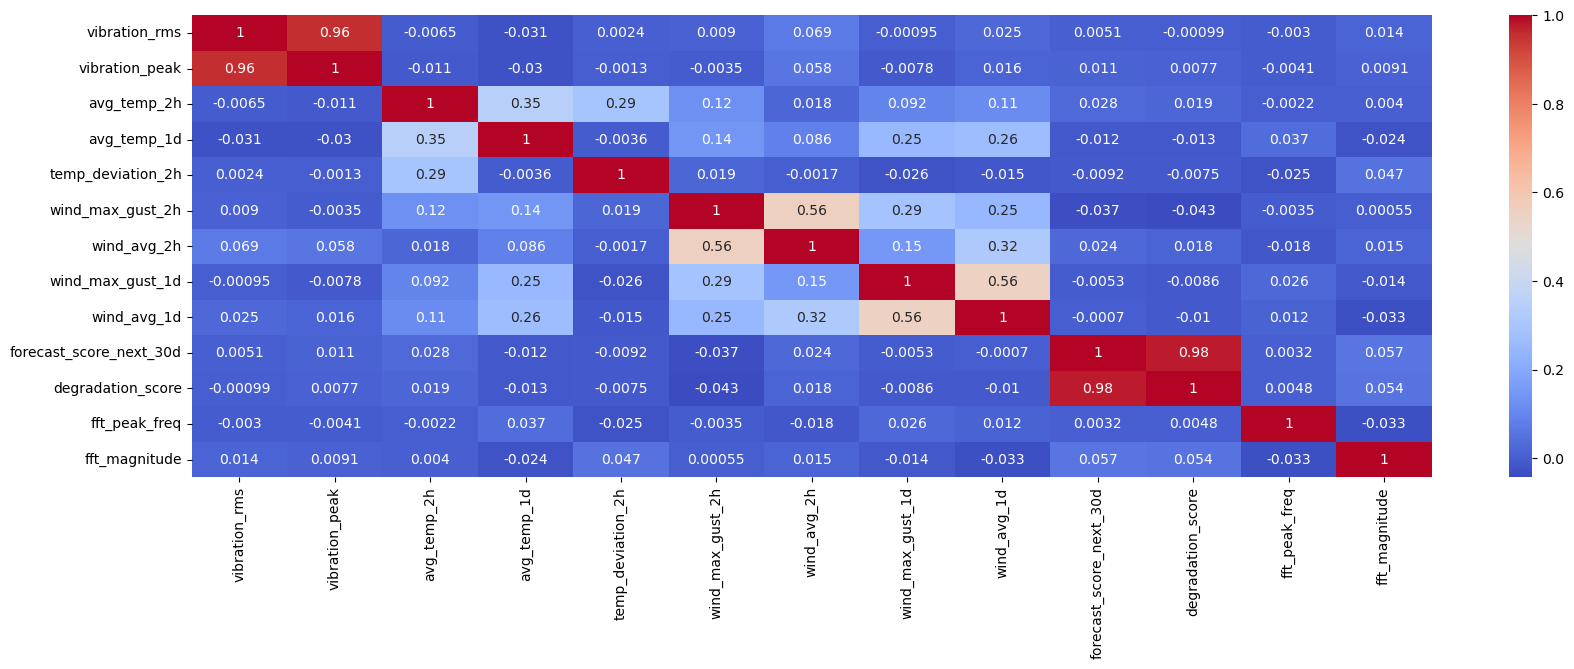

In [18]:
corr = df[features].corr(numeric_only=True)
plt.figure(figsize = (20,6))
sns.heatmap(corr , annot = True , cmap = "coolwarm")

In [19]:
df.to_csv("../Data/Processed/featured_dataset_V2.csv", index= False)

In [20]:
df.columns

Index(['acceleration_x', 'acceleration_y', 'acceleration_z', 'temperature_c',
       'humidity_percent', 'wind_speed_mps', 'fft_peak_freq', 'fft_magnitude',
       'degradation_score', 'structural_condition', 'damage_class',
       'forecast_score_next_30d', 'date', 'time', 'vibration_rms',
       'vibration_peak', 'avg_temp_2h', 'avg_temp_1d', 'temp_deviation_2h',
       'wind_max_gust_2h', 'wind_avg_2h', 'wind_max_gust_1d', 'wind_avg_1d'],
      dtype='object')